# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris
from typing import Union

# Load Dataset

### Load the iris dataset from sklearn (1 Mark)

In [2]:
data = load_iris(as_frame=True)
data = data['frame']
print(data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


# Preprocess

Segregating the dataset into two different halves to allow two different perceptrons to train on the separate datasets.

The concept is to have one perceptron determine between flower type 1 and others and the other perceptron to determine between flower type 2 and 3.

In [3]:
def modifyData_1(x) :
  if x['target'] == 0 :
    x['target'] = -1
    return x
  else :
    x['target'] = 1
    return x

def modifyData_2(x) :
  if x['target'] == 1 :
    x['target'] = 1
    return x
  else :
    x['target'] = -1
    return x

data_1 = data.apply(modifyData_1, axis=1)
data_2 = data[data['target'] != 0].apply(modifyData_2, axis=1)

print(len(data_1))
print(len(data_2))

150
100


Separating into features and target classes and converting the dataset to numpy ndarray for easier processing.

In [4]:
X_1 = data_1.drop('target', axis=1).to_numpy()
Y_1 = data_1['target'].to_numpy()

X_2 = data_2.drop('target', axis=1).to_numpy()
Y_2 = data_2['target'].to_numpy()

print(X_1.shape)
print(Y_1.shape)
print(X_2.shape)
print(Y_2.shape)

(150, 4)
(150,)
(100, 4)
(100,)


### Split the dataset into train and test sets in a ratio of 70%-30%(1 Mark)

In [5]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.3, random_state=42)
print(x_train_1.shape)
print(x_test_1.shape)
print(y_train_1.shape)
print(y_test_1.shape)

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.3, random_state=42)
print(x_train_2.shape)
print(x_test_2.shape)
print(y_train_2.shape)
print(y_test_2.shape)

(105, 4)
(45, 4)
(105,)
(45,)
(70, 4)
(30, 4)
(70,)
(30,)


# Perceptron

In [6]:
class CustomPerceptron:
    """
    Custom implementation of a perceptron classifier.
    """
    def __init__(self, num_features: int, lr: float=2e2):
        """
        Initialize the perceptron with the given number of features and learning rate.

        Args
        ----
        num_features (int): Number of input features.
        lr (float): Learning rate for weight updates.
        """

        # Initializing the weight vector with zeros, including an extra slot for the bias
        self.W = np.zeros((num_features + 1))
        # Assigning the learning rate to control the step size during updates
        self.lr = lr

    def signum(self, x: int) -> int:
        """
        Perceptron activation function

        Args
        ----
        x (int): Input value.

        Returns
        -------
        int: 1 if x >= 0, -1 otherwise.
        """

        return 1 if x >= 0 else -1


    def forward(self, x: Union[np.ndarray, pd.DataFrame]) -> int:
        """
        Forward pass through the perceptron.

        Args
        ----
        x (array-like): Input features.

        Returns
        -------
        int: Predicted class (-1 or 1).
        """
        # Appending a constant 1 to the input vector to account for the bias term
        x = np.append(x, [1])
        # Calculating the dot product and passing it through the activation function
        res = self.signum(self.W @ x)
        return res

    def loss(self, pred: int, target: int) -> int:
        """
        Calculate the loss.

        Args
        ----
        pred (int): Predicted class.
        target (int): Target class.

        Returns
        -------
        int: Loss value.
        """

        # Multiplying prediction and target to check if the classification is correct
        return pred * target

    def update(self, error: int, input: Union[np.ndarray, pd.DataFrame], target: Union[np.ndarray, pd.DataFrame]) -> None:
        """
        Update the weights.

        Args
        ----
        error (int): Loss value.
        input (array-like): Input features.
        target (array-like): Target class.
        """

        # Updating the weight vector based on the error
        # Checking if a misclassification occurred (where error < 0)
        if error < 0:
            # Extending the input vector with a bias trigger before updating
            input = np.append(input, [1])
            # Adjusting the weight vector by moving it toward the target class
            self.W = self.W + self.lr * input * target


    def train(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.DataFrame], max_epochs: int=1000, patience: int=5) -> tuple[list, int]:
        """
        Train the perceptron model until data is separated or max_epochs is reached.

        Args
        ----
        X (array-like): Training features.
        y (array-like): Target labels.
        max_epochs (int): Maximum number of epochs to run to avoid infinite loops.
        patience (int): Number of epochs to wait for improvement before stopping.

        Returns
        -------
        tuple[list, int]: History of misclassification counts per epoch and the epoch count
        """

        if patience > max_epochs:
            raise ValueError("Patience cannot be greater than max_epochs")
        if patience <= 0:
            raise ValueError("Patience must be a positive integer")

        misclassifications = []
        num_misclassifications = np.inf
        num_misclassifications_best = np.inf
        not_best_count = 0
        epoch = 0

        while num_misclassifications > 0 and epoch < max_epochs and not_best_count < patience:
            num_misclassifications = 0

            for i in range(len(X)):

                pred = self.forward(X[i])

                error = self.loss(pred, y[i])

                # Tracking the count of incorrect predictions within the current epoch
                if error < 0:
                    num_misclassifications += 1
                    # Updating the weight vector whenever a misclassification is detected
                    self.update(error, X[i], y[i])

            # Incrementing the epoch counter after completing a full pass
            epoch += 1
            # Appending the total error count to a list for later performance analysis
            misclassifications.append(num_misclassifications)

            if num_misclassifications < num_misclassifications_best:
                num_misclassifications_best = num_misclassifications
                not_best_count = 0
            else:
                not_best_count += 1

            print(f"Number of misclassifications: {num_misclassifications} in epoch {epoch}")

        return misclassifications, epoch

# Train

Train loop for training two models of the perceptron on two halves of the dataset.

In [7]:
lr = 2e2
max_epochs = 1000
patience = 5

model_A = CustomPerceptron(X_1.shape[1], lr)
misclassifications_A, epochs_A = model_A.train(x_train_1, y_train_1, max_epochs=max_epochs, patience=patience)

Number of misclassifications: 7 in epoch 1
Number of misclassifications: 0 in epoch 2


In [8]:
model_B = CustomPerceptron(X_2.shape[1], lr)
misclassifications_B, epochs_B = model_B.train(x_train_2, y_train_2, max_epochs=max_epochs, patience=patience)

Number of misclassifications: 32 in epoch 1
Number of misclassifications: 27 in epoch 2
Number of misclassifications: 20 in epoch 3
Number of misclassifications: 13 in epoch 4
Number of misclassifications: 20 in epoch 5
Number of misclassifications: 15 in epoch 6
Number of misclassifications: 17 in epoch 7
Number of misclassifications: 2 in epoch 8
Number of misclassifications: 9 in epoch 9
Number of misclassifications: 0 in epoch 10


# Plots

### Plot the variation of the number of misclassified examples with the number of iterations of each perceptron classifier.

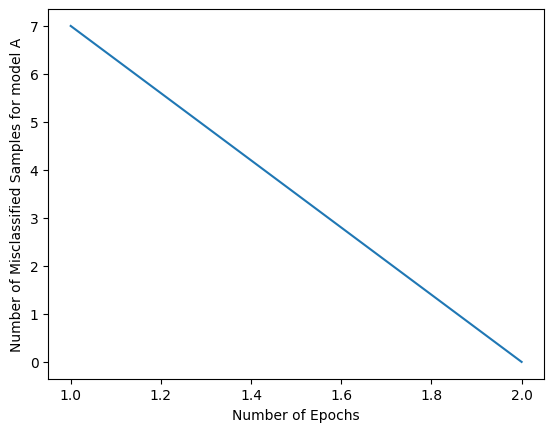

In [9]:
plt.plot(np.arange(1,epochs_A+1), misclassifications_A)
plt.xlabel('Number of Epochs')
plt.ylabel('Number of Misclassified Samples for model A')
plt.show()

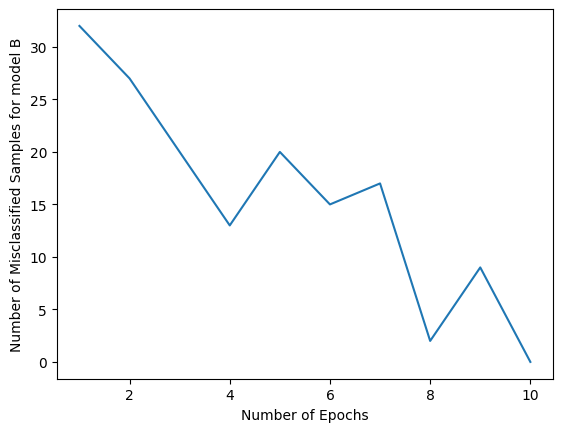

In [10]:
plt.plot(np.arange(1,epochs_B+1), misclassifications_B)
plt.xlabel('Number of Epochs')
plt.ylabel('Number of Misclassified Samples for model B')
plt.show()

# Test

### Generate the predictions on the test set, and report the accuracy, precision and recall performances.

In [11]:
def classify_flower(data: np.ndarray) -> int :
  """
  Method to classify flower type using two perceptrons
  Args
  ----
  data (np.ndarray): features array for testing

  Returns
  -------
  int: predicted flower type
  """

  res_1 = model_A.forward(data)
  if res_1 == -1 :
    return 0
  else :
    res_2 = model_B.forward(data)
    if res_2 == 1 :
      return 1
    else :
      return 2

For testing purposes, the whole original dataset will be used as the existing dataset was modified for training and is not suitable for testing.

In [12]:
og_data = load_iris(as_frame=True)
og_data = og_data['frame']

X = og_data.drop('target', axis=1).to_numpy()
Y = og_data['target'].to_numpy()

preds = []
for row in X :
  preds.append(classify_flower(row))

accuracy = accuracy_score(Y, preds)
precision = precision_score(Y, preds, average='macro')
recall = recall_score(Y, preds, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.98
Precision: 0.9811320754716982
Recall: 0.98


### Generate the class predictions with sklearn’s implementation of perceptron. Compare the corresponding performance metrics (accuracy, precision, recall) with your implementation.

In [13]:
model_A = Perceptron(eta0=lr, max_iter=max_epochs)
model_A.fit(x_train_1, y_train_1)

model_B = Perceptron(eta0=lr, max_iter=max_epochs)
model_B.fit(x_train_2, y_train_2)

Perceptron(eta0=200.0)

In [14]:
def classify_flower_sklearn(data: np.ndarray) -> int :
  """
  Method to classify flower type using two perceptrons
  Args
  ----
  data (np.ndarray): features array for testing

  Returns
  -------
  int: predicted flower type
  """

  res_1 = model_A.predict(data.reshape(1, -1))
  if res_1 == -1 :
    return 0
  else :
    res_2 = model_B.predict(data.reshape(1, -1))
    if res_2 == 1 :
      return 1
    else :
      return 2

In [15]:
preds = []
for row in X :
  preds.append(classify_flower_sklearn(row))

accuracy = accuracy_score(Y, preds)
precision = precision_score(Y, preds, average='macro')
recall = recall_score(Y, preds, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9866666666666667
Precision: 0.9871794871794872
Recall: 0.9866666666666667


The Scikit-learn model performs slightly better than my implementation

### From the performances obtained, what can you conclude about the separability of the dataset? Are any of the classes linearly separable from the others? Justify your answer

The metrics indicate that the dataset's classes are almost linearly separable, but not entirely, as seen by the very high but not 1.0 accuracy, precision, and recall scores on the test set.
However, directly visualizing this decision boundary without losing information is not possible because the dataset has four features, making it impossible to plot directly in two or three dimensions.
